# Classify

Classification is a methodology that tries to match a text to the correct label. 

### Prompt based classification 

Prompt based classification is a methodology that relies purely on prompting the LLM in a specific way. 

### When should you use prompt based classification 

Some situations when you would use this methodology is when:
- The labels are easily understood (they don't require explanation or examples)
    
    An example is sentiment analysis
- The labels are not recognized by their semantic meaning
    
    E.g. Reasoning tasks like classifying contradictions
- You don't have many examples

### Example snippet 
Running the following code will instantiate a prompt based classifier, with a debug level for the log. 
Then it will classify the text given in "ClassifyInput".
The contents of the debuglog will be shown below.
The debuglog gives an overview of the steps taken to get the result.

In [62]:
from os import getenv
from aleph_alpha_client import Client
from intelligence_layer.classify import SingleLabelClassify, ClassifyInput
from pprint import pprint

text_to_classify = "In the distant future, a space exploration party embarked on a thrilling journey to the uncharted regions of the galaxy. \n\
    With excitement in their hearts and the cosmos as their canvas, they ventured into the unknown, discovering breathtaking celestial wonders. \n\
    As they gazed upon distant stars and nebulas, they forged unforgettable memories that would forever bind them as pioneers of the cosmos."
labels = ["happy", "angry", "sad"]
client = Client(getenv("AA_API_TOKEN"))
task = SingleLabelClassify(client, "info")
input = ClassifyInput(
    text=text_to_classify, 
    labels=labels
)

output = task.run(input)
for label, score in output.scores.items():
    print(f"{label}: {round(score, 4)}")
output.debug_log

happy: 0.6867
sad: 0.3065
angry: 0.0068


### How does this implemetation work
For prompt based classification, we prompt the model multiple times with the text we want to classify and each of our classes. 
Instead of letting the model generate the class it thinks fits the text best, we ask it for the probability for each class.

To further explain this, lets start with a more familiar case.
The intuitive way to ask an LLM if it could label a text could be something like this: 

In [63]:
from aleph_alpha_client import PromptTemplate

prompt_template = PromptTemplate(SingleLabelClassify.PROMPT_TEMPLATE) 
print(prompt_template.to_prompt(text=text_to_classify, label="").items[0].text)

### Instruction:
Identify a class that describes the text adequately.
Reply with only the class label.

### Input:
In the distant future, a space exploration party embarked on a thrilling journey to the uncharted regions of the galaxy. 
    With excitement in their hearts and the cosmos as their canvas, they ventured into the unknown, discovering breathtaking celestial wonders. 
    As they gazed upon distant stars and nebulas, they forged unforgettable memories that would forever bind them as pioneers of the cosmos.

### Response:


The model would then answer our question, and give us a class that it thinks fits the text. 

In the case of classification, however, we already have the classes beforehand.
Because of this, all we are interested in is the probability the model would have guessed our specific classes.
To get this probability, we can prompt the model with each of our classes and ask the model to return the logprobs for the text. 

In case of prompt based classification the prompt looks something like this:

In [64]:
prompt_template = PromptTemplate(SingleLabelClassify.PROMPT_TEMPLATE) 
print(prompt_template.to_prompt(text=text_to_classify, label=labels[0]).items[0].text)

### Instruction:
Identify a class that describes the text adequately.
Reply with only the class label.

### Input:
In the distant future, a space exploration party embarked on a thrilling journey to the uncharted regions of the galaxy. 
    With excitement in their hearts and the cosmos as their canvas, they ventured into the unknown, discovering breathtaking celestial wonders. 
    As they gazed upon distant stars and nebulas, they forged unforgettable memories that would forever bind them as pioneers of the cosmos.

### Response:happy


As you can see, we have the same prompt, but with the class already filled in as a response.

Our request will now not generate any tokens, but instead will just return us the logprobs that the class would be generated, given the previous tokens.

```python
CompletionRequest(
    prompt=prompt_template.to_prompt(**kwargs),
    maximum_tokens=0,
    log_probs=0,
    tokens=True,
    echo=True,
)
```

In the case of the classes "Space exploration" and "Space party", the logprobs per label might look something like the code snippet below. 

In [65]:
from intelligence_layer.task import InfoEnabledLog 
result_objects = [log_entry for log_entry in output.debug_log.root if log_entry.message == "Raw log probs per label"]
InfoEnabledLog(root=result_objects)

Now that we have the logprobs, we just need to do some calculations to turn them into our end score. 

To turn the logprobs into our end scores, first we normalize our probabilities. This will result in the following data structure:

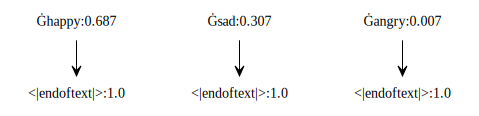

In [66]:
from IPython import display
from intelligence_layer.classify import TreeNode
from intelligence_layer.tree_visualizer import graph_nodes

normalized_probs_logs = [log_entry.value for log_entry in output.debug_log.root if log_entry.message == "Normalized Probs"]
log = normalized_probs_logs.pop()

root = TreeNode()
for probs in log.values():
    root.insert_without_calculation(probs)

graph = graph_nodes(root)
display.display_svg(graph)

Finally, we take the product of all the paths to get the following results:

In [67]:
for label, score in output.scores.items():
    print(f"{label}: {round(score, 5)}")

happy: 0.68669
sad: 0.30653
angry: 0.00677


The example mentioned before is rather straightforward, but there are some situations when it isn't as obvious as a single token.

What if we take some classes that have some overlap?
In the following example some of the classes overlap in the tokens they have. This makes the calculation a bit more complicated:

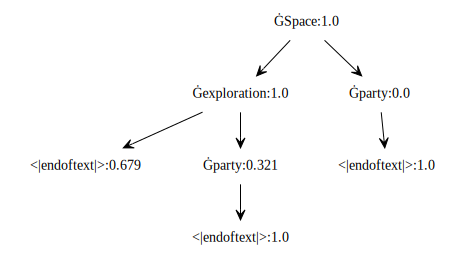

End scores:
Space exploration: 0.6788
Space exploration party: 0.3211
Space party: 0.0


In [70]:
from intelligence_layer.classify import SingleLabelClassify, ClassifyInput

labels = ["Space party", "Space exploration", "Space exploration party"]
task = SingleLabelClassify(client, "info")
input = ClassifyInput(
    text=text_to_classify, 
    labels=labels
)
output = task.run(input)
normalized_probs_logs = [log_entry.value for log_entry in output.debug_log.root if log_entry.message == "Normalized Probs"]
log = normalized_probs_logs.pop()

root = TreeNode()
for probs in log.values():
    root.insert_without_calculation(probs)

graph = graph_nodes(root)
display.display_svg(graph)
print("End scores:")
for label, score in output.scores.items():
    print(f"{label}: {round(score, 4)}")

Here the three classes have some overlapping tokens. 
In the graph above can be seen how the calculations would be done in this case. 

1. At the top, you can see that when there is only one token to choose from, the normalized score will always be 1.

2. After that, the first choice is made between "exploration" and "party". 

3. If the choice of "exploration" is made, finally a choice has to be made between the "endoftext" token and "party".

    This "endoftext" token is a token that large language models use internally to make their calculations.
    As an end user, you generally shouldn't see this token.

    In our case, this translates to choosing between: "Space exploration party" and just "Space exploration".
